In [1]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color, plot_loss
from utils import compute_metric_dc, data_aug
import nibabel as nib
from sklearn.model_selection import KFold
from loss_fn import *
%matplotlib inline

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 8
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'model_vnet05' #save version
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer

---

# Helper Functions

---

----

# Model

In [3]:
from tensorflow.keras.layers import Conv3D, UpSampling3D, MaxPool3D, GaussianNoise
from tensorflow.keras.layers import Input, BatchNormalization, PReLU, ReLU, Dropout
from tensorflow.keras.layers import Add, Multiply, Activation
from tensorflow.keras import Model
from utils_model import *
from attention import *

hn = 'he_normal' #kernel initializer

def DeepAttVnet(x):
    #filter list depth of 4
    f_list = [8, 16, 32, 64, 128]
    # inject gaussian noise
    gauss1 = GaussianNoise(0.01)(x)

    # -----------down sampling path--------------------------------------
    # 1st block [128, 160, 160, 4]
    conv01 = conv_block_3D(x, filters=[f_list[0], f_list[0]])
    # 2nd block [64, 80, 80, 4]
    down_01 = MaxPool3D()(conv01)
    conv02 = conv_block_3D(down_01, filters=[f_list[1], f_list[1]])
    # 3rd block [32, 40, 40, 4]
    down_02 = MaxPool3D()(conv02)
    conv03 = conv_block_3D(down_02, filters=[f_list[2], f_list[2]])
    # 4th block [16, 20, 20, 4]
    down_03 = MaxPool3D()(conv03)
    conv04 = conv_block_3D(down_03, filters=[f_list[3], f_list[3]])
    # 5th block [8, 10, 10, 4]
    down_04 = MaxPool3D()(conv04)
    conv05 = conv_block_3D(down_04, filters=[f_list[4], f_list[4]])

    # -----------up sampling path-----------------------------------------
    # 1st attention block---
    att_01 = attention_block_3D(conv04, conv05, f_list[3])
    # 1st up [16, 20, 20, 4]
    up_01 = up_3D(conv05, f_list[3], att_01)
    up_conv01 = conv_block_3D(up_01, filters=[f_list[3], f_list[3]])

    # 2nd attention block---
    att_02 = attention_block_3D(conv03, up_conv01, f_list[2])
    # 2nd up [32, 40, 40, 4]
    up_02 = up_3D(up_conv01, f_list[2], att_02)
    up_conv02 = conv_block_3D(up_02, filters=[f_list[2], f_list[2]])
    # 2nd block segmentation output
    seg_02 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv02)

    # 3rd attention block---
    att_03 = attention_block_3D(conv02, up_conv02, f_list[1])
    # 3rd up [64, 80, 80, 4]
    up_03 = up_3D(up_conv02, f_list[1], att_03)
    up_conv03 = conv_block_3D(up_03, filters=[f_list[1], f_list[1]])
    # 3rd block segmentation output
    seg_03 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv03)

    # 4th attention block---
    att_04 = attention_block_3D(conv01, up_conv03, f_list[0])
    # 4th up [128, 160, 160, 4]
    up_04 = up_3D(up_conv03, f_list[1], att_04)
    up_conv04 = conv_block_3D(up_04, filters=[f_list[0], f_list[0]])
    # 4th block segmentation output
    seg_04 = Conv3D(4, kernel_size=1, padding='same', kernel_initializer=hn)(up_conv04)

    # Deep Supervision---
    #Add all segmentation output before inputting into the output layer
    #upsample to fit the size of seg_03
    seg_02_up = UpSampling3D(size=2)(seg_02)
    add_0203 = Add()([seg_02_up,seg_03])
    #upsample to fit the size of seg_03
    add_0203_up = UpSampling3D(size=2)(add_0203)
    add_020304 = Add()([add_0203_up, seg_04])

    #segmentation output
    output = Conv3D(4,kernel_size=1, activation='softmax',
                    kernel_initializer=hn)(add_020304)
    return output

In [4]:
#Build Model
input_layer = Input(shape=(128,160,160,4))
model = Model(input_layer, DeepAttVnet(input_layer))

In [5]:
xent = tf.keras.losses.CategoricalCrossentropy()

@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image, training=True)
        loss, l_xent, l_dc  = custom_loss(label, model_output)
        l_list = [loss, l_xent, l_dc]
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

    return model_output, l_list, gradients

---


Epochs  1



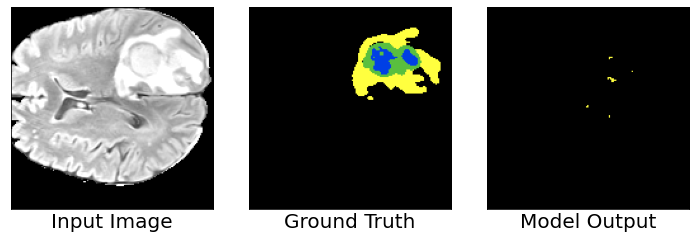

Steps: 300, L_xent: 0.20785711705684662, L_dc: 0.9494391679763794
Total loss: 1.1572962999343872
Accurary: 0.9076562523841858
Seq: TC, ET, WT
Dice coefficient: [0.846875, 0.83125, 0.7716561072971672]
Gradient min:-0.03221850097179413, max:0.03898589685559273
Compute time per epochs: 11.02 mins

Epochs  2



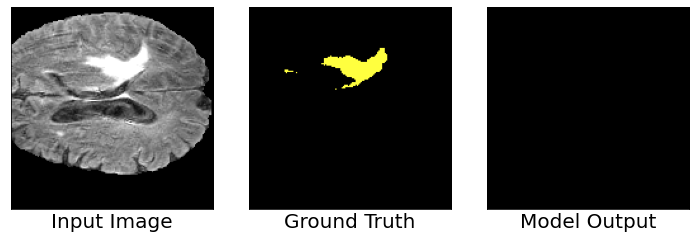

Steps: 300, L_xent: 0.24052968621253967, L_dc: 0.8097820281982422
Total loss: 1.0503116846084595
Accurary: 0.9727343916893005
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.93125]
Gradient min:-0.12296614050865173, max:0.13093361258506775
Compute time per epochs: 10.73 mins

Epochs  3



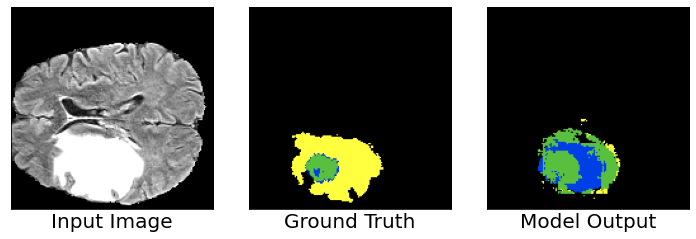

Steps: 300, L_xent: 0.1208442822098732, L_dc: 0.8196367621421814
Total loss: 0.9404810667037964
Accurary: 0.8994531035423279
Seq: TC, ET, WT
Dice coefficient: [0.7386056274990551, 0.7431678671622649, 0.706931319537883]
Gradient min:-0.05578388273715973, max:0.06494081765413284
Compute time per epochs: 10.73 mins

Epochs  4



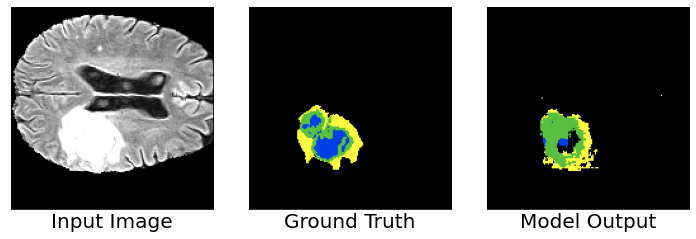

Steps: 300, L_xent: 0.0438876636326313, L_dc: 0.6612704992294312
Total loss: 0.7051581740379333
Accurary: 0.9523828029632568
Seq: TC, ET, WT
Dice coefficient: [0.8201592072844506, 0.8462996037676931, 0.8017938845170041]
Gradient min:-0.16496579349040985, max:0.24250955879688263
Compute time per epochs: 10.71 mins

Epochs  5



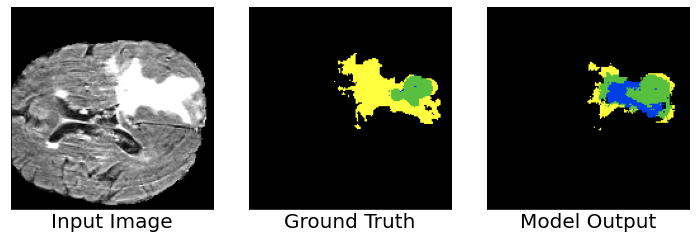

Steps: 300, L_xent: 0.09543921053409576, L_dc: 0.5752118825912476
Total loss: 0.6706510782241821
Accurary: 0.9377734661102295
Seq: TC, ET, WT
Dice coefficient: [0.8372482247417793, 0.8613385547418148, 0.8001864136972775]
Gradient min:-0.10698892921209335, max:0.19061094522476196
Compute time per epochs: 11.56 mins

Epochs  6



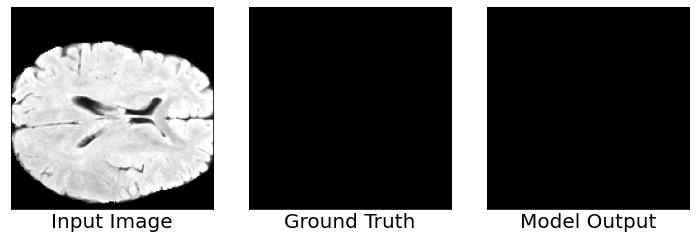

Steps: 300, L_xent: 0.20005950331687927, L_dc: 0.9576606154441833
Total loss: 1.1577200889587402
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.15329846739768982, max:0.19932051002979279
Compute time per epochs: 10.73 mins

Epochs  7



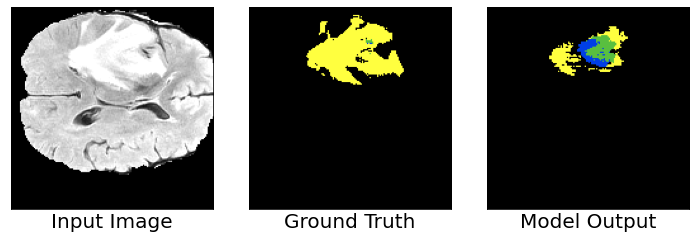

Steps: 300, L_xent: 0.10939303040504456, L_dc: 0.4835761785507202
Total loss: 0.5929691791534424
Accurary: 0.9317968487739563
Seq: TC, ET, WT
Dice coefficient: [0.8675942166941241, 0.8726884333882481, 0.82878721319139]
Gradient min:-0.2329692393541336, max:0.11005670577287674
Compute time per epochs: 10.73 mins

Epochs  8



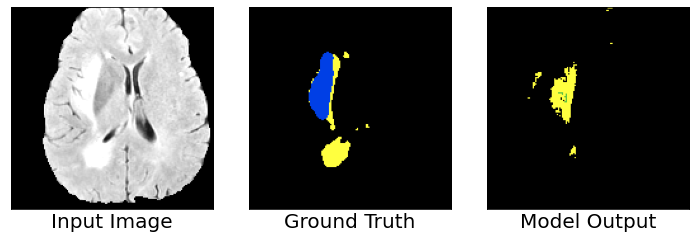

Steps: 300, L_xent: 0.2134512960910797, L_dc: 0.8152505159378052
Total loss: 1.0287017822265625
Accurary: 0.9524219036102295
Seq: TC, ET, WT
Dice coefficient: [0.80625, 0.95, 0.7247121721195678]
Gradient min:-0.28702205419540405, max:0.21091187000274658
Compute time per epochs: 10.73 mins

Epochs  9



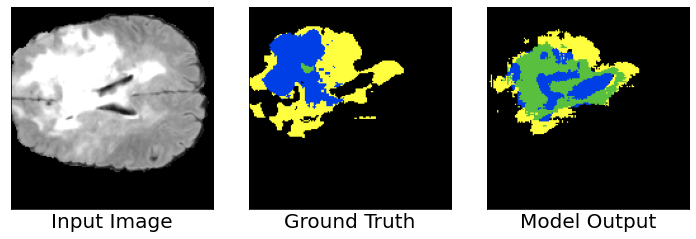

Steps: 300, L_xent: 0.29610079526901245, L_dc: 0.9631352424621582
Total loss: 1.2592360973358154
Accurary: 0.8309765458106995
Seq: TC, ET, WT
Dice coefficient: [0.6368857205612585, 0.6154036539141089, 0.6494987716587881]
Gradient min:-0.19745445251464844, max:0.10905332118272781
Compute time per epochs: 10.71 mins

Epochs 10



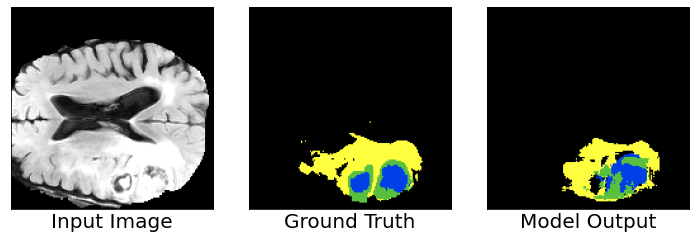

Steps: 300, L_xent: 0.08383680880069733, L_dc: 0.5015816688537598
Total loss: 0.5854184627532959
Accurary: 0.9413281083106995
Seq: TC, ET, WT
Dice coefficient: [0.879770431551151, 0.8775558407884091, 0.8642529546748847]
Gradient min:-0.05918724834918976, max:0.10330060124397278
Compute time per epochs: 11.34 mins

Epochs 11



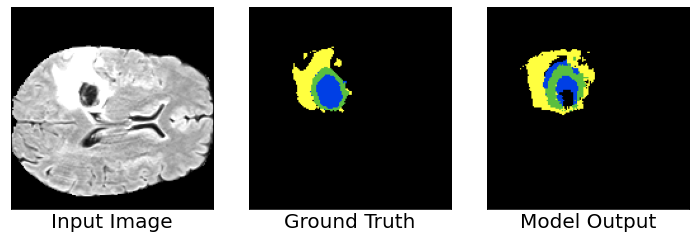

Steps: 300, L_xent: 0.059710822999477386, L_dc: 0.43913745880126953
Total loss: 0.4988482892513275
Accurary: 0.9538280963897705
Seq: TC, ET, WT
Dice coefficient: [0.8648435678333044, 0.8837793339975178, 0.8500422175042331]
Gradient min:-0.18309330940246582, max:0.1819440722465515
Compute time per epochs: 10.73 mins

Epochs 12



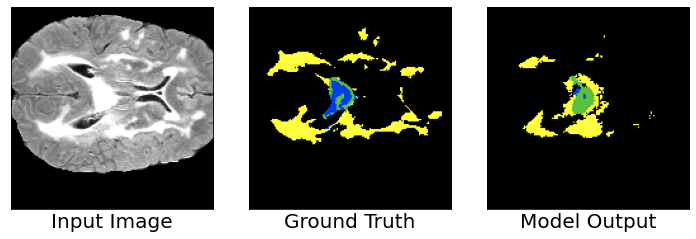

Steps: 300, L_xent: 0.21864555776119232, L_dc: 0.5787824392318726
Total loss: 0.7974280118942261
Accurary: 0.9137890338897705
Seq: TC, ET, WT
Dice coefficient: [0.8263753743842244, 0.8717317104339599, 0.734783505834639]
Gradient min:-0.39356547594070435, max:0.43140703439712524
Compute time per epochs: 10.70 mins

Epochs 13



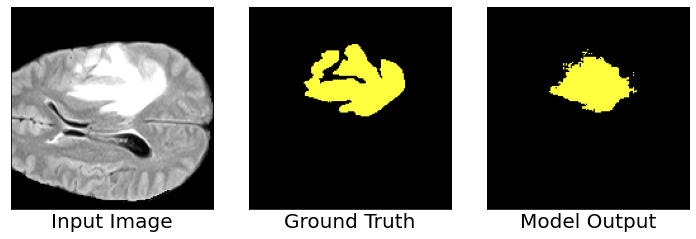

Steps: 300, L_xent: 0.11493831872940063, L_dc: 0.501871645450592
Total loss: 0.6168099641799927
Accurary: 0.9515625238418579
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9486235784677167]
Gradient min:-0.3207626938819885, max:0.3403337597846985
Compute time per epochs: 10.72 mins

Epochs 14



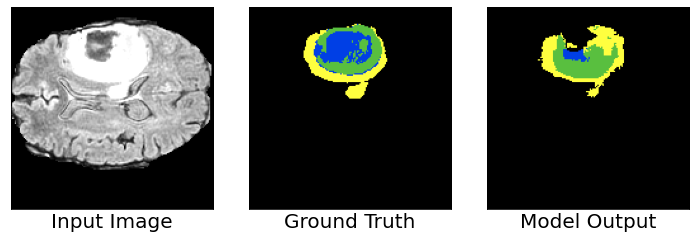

Steps: 300, L_xent: 0.06625837832689285, L_dc: 0.5208508968353271
Total loss: 0.5871092677116394
Accurary: 0.9435937404632568
Seq: TC, ET, WT
Dice coefficient: [0.8179687360418029, 0.8511763472575694, 0.8199613489753877]
Gradient min:-0.41153568029403687, max:0.4503496587276459
Compute time per epochs: 10.74 mins

Epochs 15



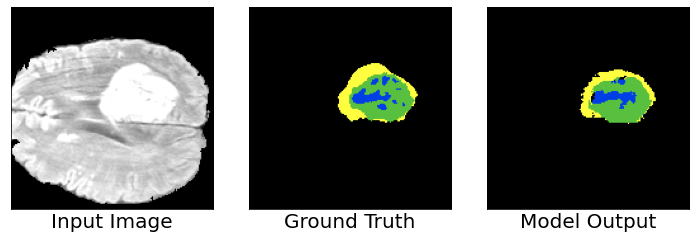

Steps: 300, L_xent: 0.045228224247694016, L_dc: 0.38470494747161865
Total loss: 0.4299331605434418
Accurary: 0.9733593463897705
Seq: TC, ET, WT
Dice coefficient: [0.9211513147456571, 0.9284500948619098, 0.9030897999337564]
Gradient min:-0.05324897542595863, max:0.06133980676531792
Compute time per epochs: 11.36 mins

Epochs 16



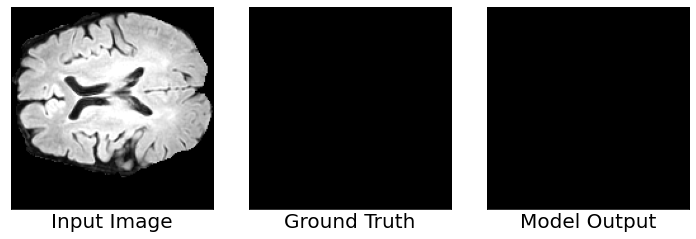

Steps: 300, L_xent: 0.04014280065894127, L_dc: 0.9721007347106934
Total loss: 1.0122435092926025
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.12493044883012772, max:0.19641733169555664
Compute time per epochs: 10.76 mins

Epochs 17



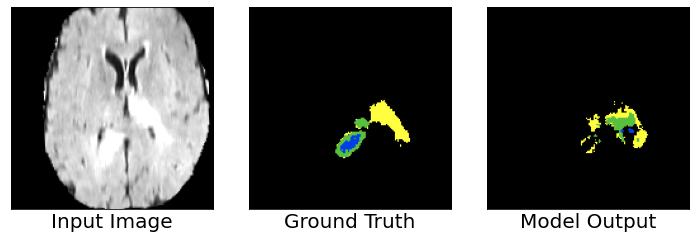

Steps: 300, L_xent: 0.05503958463668823, L_dc: 0.5980089902877808
Total loss: 0.653048574924469
Accurary: 0.9652734398841858
Seq: TC, ET, WT
Dice coefficient: [0.8345792019856162, 0.7879084039712325, 0.8269645072442169]
Gradient min:-0.4693918526172638, max:0.2653908431529999
Compute time per epochs: 10.77 mins

Epochs 18



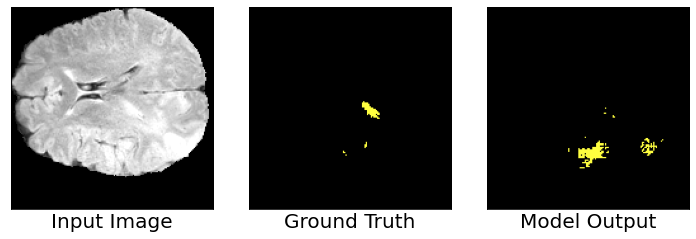

Steps: 300, L_xent: 0.03730425983667374, L_dc: 0.526357889175415
Total loss: 0.5636621713638306
Accurary: 0.9855859279632568
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9225841544413318]
Gradient min:-0.5361944437026978, max:0.27085351943969727
Compute time per epochs: 10.78 mins

Epochs 19



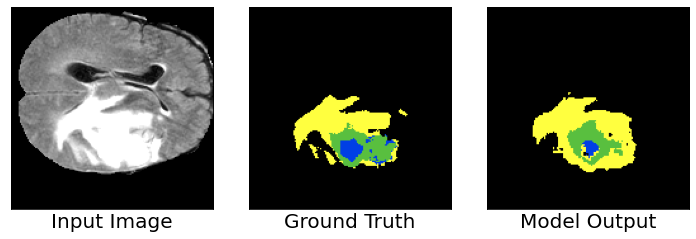

Steps: 300, L_xent: 0.08281835913658142, L_dc: 0.3371831774711609
Total loss: 0.4200015366077423
Accurary: 0.9544140696525574
Seq: TC, ET, WT
Dice coefficient: [0.9003009472973644, 0.9027338934130966, 0.8772549583033348]
Gradient min:-0.121003657579422, max:0.30661579966545105
Compute time per epochs: 10.77 mins

Epochs 20



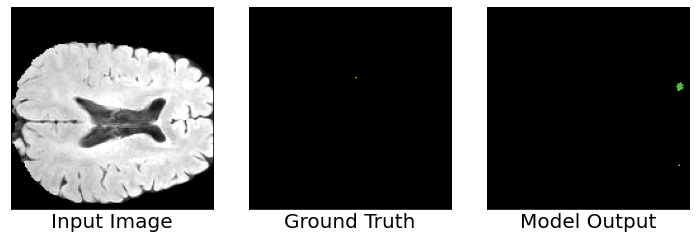

Steps: 300, L_xent: 0.061047159135341644, L_dc: 0.6614323258399963
Total loss: 0.7224794626235962
Accurary: 0.9989062547683716
Seq: TC, ET, WT
Dice coefficient: [0.978125, 0.95625, 0.98125]
Gradient min:-0.16628006100654602, max:0.09856145828962326
Compute time per epochs: 11.38 mins

Epochs 21



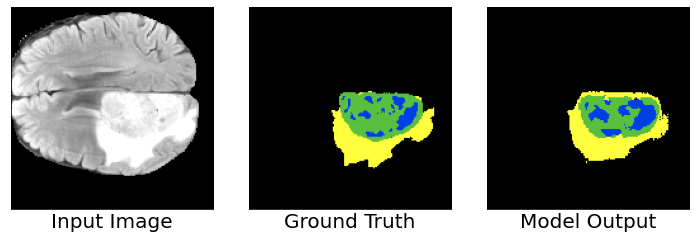

Steps: 300, L_xent: 0.06702558696269989, L_dc: 0.4536556601524353
Total loss: 0.5206812620162964
Accurary: 0.9608984589576721
Seq: TC, ET, WT
Dice coefficient: [0.9164479222381487, 0.9231129428371787, 0.8915594283336152]
Gradient min:-0.16096185147762299, max:0.0770665854215622
Compute time per epochs: 10.76 mins

Epochs 22



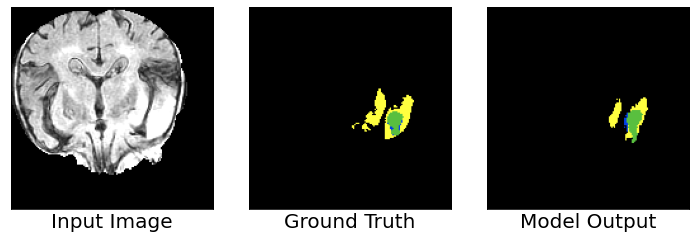

Steps: 300, L_xent: 0.034055572003126144, L_dc: 0.8593800663948059
Total loss: 0.8934356570243835
Accurary: 0.9844921827316284
Seq: TC, ET, WT
Dice coefficient: [0.9223983626812696, 0.9416717253625393, 0.9005051119408259]
Gradient min:-0.10604345798492432, max:0.09039702266454697
Compute time per epochs: 10.77 mins

Epochs 23



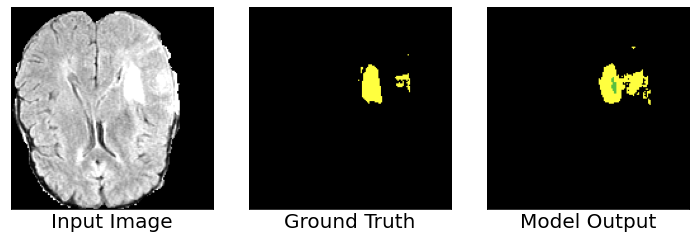

Steps: 300, L_xent: 0.02584707736968994, L_dc: 0.409950315952301
Total loss: 0.43579739332199097
Accurary: 0.986328125
Seq: TC, ET, WT
Dice coefficient: [0.959375, 0.91875, 0.9422236327702801]
Gradient min:-0.14858460426330566, max:0.2444791942834854
Compute time per epochs: 10.75 mins

Epochs 24



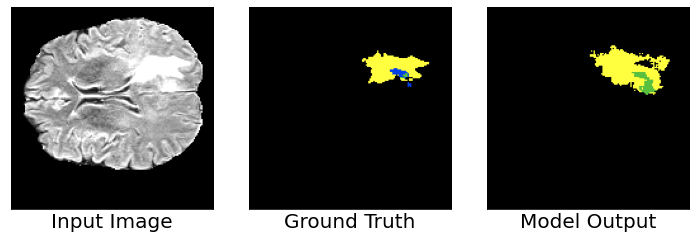

Steps: 300, L_xent: 0.05064326524734497, L_dc: 0.46504300832748413
Total loss: 0.5156862735748291
Accurary: 0.9725000262260437
Seq: TC, ET, WT
Dice coefficient: [0.9117507494054735, 0.898501498810947, 0.8952323886876304]
Gradient min:-0.09388010948896408, max:0.04981446638703346
Compute time per epochs: 10.74 mins

Epochs 25



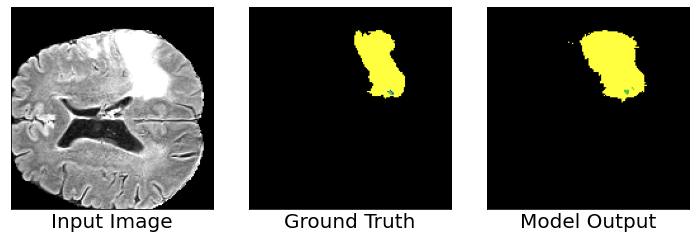

Steps: 300, L_xent: 0.057349830865859985, L_dc: 0.48469942808151245
Total loss: 0.5420492887496948
Accurary: 0.9776172041893005
Seq: TC, ET, WT
Dice coefficient: [0.972916666790843, 0.970833333581686, 0.9529929944624503]
Gradient min:-0.07577948272228241, max:0.06812583655118942
Compute time per epochs: 11.37 mins

Epochs 26



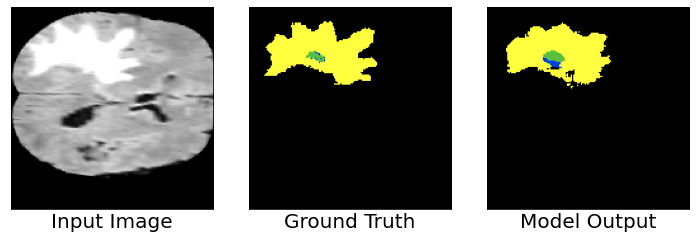

Steps: 300, L_xent: 0.08541048318147659, L_dc: 0.2672538161277771
Total loss: 0.3526642918586731
Accurary: 0.9729687571525574
Seq: TC, ET, WT
Dice coefficient: [0.9482295375782996, 0.9704174084588886, 0.9373683945586284]
Gradient min:-0.09481362253427505, max:0.11674824357032776
Compute time per epochs: 10.77 mins

Epochs 27



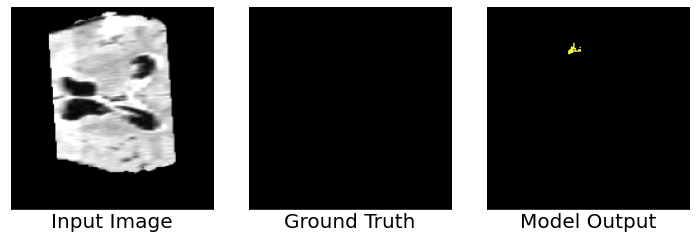

Steps: 300, L_xent: 0.08294814825057983, L_dc: 0.7147762179374695
Total loss: 0.7977243661880493
Accurary: 0.9987109303474426
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.98125]
Gradient min:-0.7218842506408691, max:0.38729822635650635
Compute time per epochs: 10.75 mins

Epochs 28



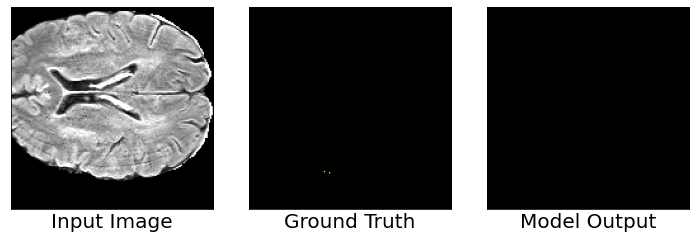

Steps: 300, L_xent: 0.0218267273157835, L_dc: 0.3002087473869324
Total loss: 0.32203546166419983
Accurary: 0.9999218583106995
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9958333333333333]
Gradient min:-0.04442572221159935, max:0.018824150785803795
Compute time per epochs: 10.76 mins

Epochs 29



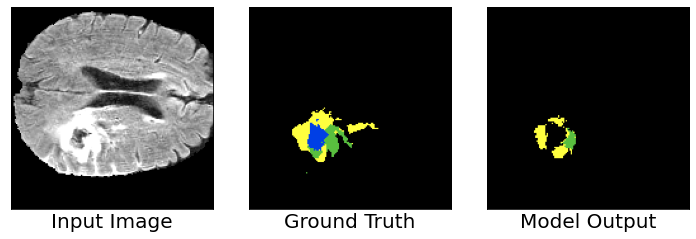

Steps: 300, L_xent: 0.1619560718536377, L_dc: 0.801303505897522
Total loss: 0.9632595777511597
Accurary: 0.9681249856948853
Seq: TC, ET, WT
Dice coefficient: [0.8665858566295356, 0.8831717132590711, 0.8623576536464195]
Gradient min:-0.6627192497253418, max:0.5582926273345947
Compute time per epochs: 10.75 mins

Epochs 30



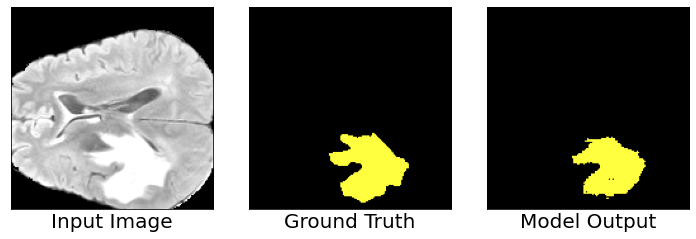

Steps: 300, L_xent: 0.0495142936706543, L_dc: 0.4355756640434265
Total loss: 0.4850899577140808
Accurary: 0.9835156202316284
Seq: TC, ET, WT
Dice coefficient: [0.99375, 0.9875, 0.9680193754844367]
Gradient min:-0.15224410593509674, max:0.09472174197435379
Compute time per epochs: 11.35 mins

----------------------------------<END>---------------------------------
Total run time for 30 epochs: 326.48 mins


In [6]:
#numpy dir
npy_dir = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/Training_pre/'
#
pre_epochs = 0
max_epochs = 30
#remainder epochs 
re_epochs = max_epochs - pre_epochs 
if pre_epochs!=0:
    model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
    upp_bound = re_epochs
else:
    upp_bound = max_epochs
    
epochs = 1
#list
loss_list = []
start_runtime = time.time()
while epochs <= upp_bound:
    start = time.time()
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    ds = os.listdir(npy_dir)
    #shuffle directory list of .npy
    shuffle = random.shuffle(ds)
    loss_inner = []
    for npy in ds:
        npy_path = os.path.join(npy_dir+npy)
        #load npy file => [155, 240, 240, 4]
        imgs = np.load(npy_path)
        #trim images [155,240,240,4] => [128,160,160,4]
        imgs = imgs[15:143,50:210,50:210,:]
        #data augmentation
        imgs = data_aug(imgs)
        #expand and slice dimes => [1,128,160,160,4]
        imgs = tf.expand_dims(imgs, axis=0)
        #image indices 
        image = imgs[...,:4]
        #unprocessed label for plotting (cropped)
        label = imgs[...,-1]
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.where(label==4,3,label)
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        #--------------<training function>----------------------------
        img_seg, l_list, gradients = train_fn(image, label)
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32)
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        #store loss total for every steps
        loss_inner.append(l_list[0].numpy())
        #save weights for every 5 epochs
        if epochs%5==0:
            model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
        #output
        slice = 70
        if steps%300==0:
            input_img = [image[0,slice,...,0], plot_labels_color(label[0,slice]), plot_labels_color(img_seg[0, slice])]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0,slice],label[0,slice]), tf.float32))
            dc_list_stp =compute_metric_dc(label[0,slice],img_seg[0,slice])
            print("Steps: {}, L_xent: {}, L_dc: {}".format(steps, l_list[1].numpy(), l_list[-1].numpy()))
            print("Total loss: {}".format(l_list[0]))
            print("Accurary: {}".format(acc_stp))
            print("Seq: TC, ET, WT")
            print("Dice coefficient: {}".format(dc_list_stp))
            print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
        steps+=1
    loss_list.append(np.mean(loss_inner))
    #end time per epochs 
    elapsed_time =(time.time()-start)/60 #unit in mins
    print("Compute time per epochs: {:.2f} mins".format(elapsed_time))
    epochs+=1
#end time for total epochs
elapsed_time_runtime = (time.time()-start_runtime)/60
print()
print('----------------------------------<END>---------------------------------')
print("Total run time for {} epochs: {:.2f} mins".format(epochs-1, elapsed_time_runtime))

---

# Save Weights

In [7]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [8]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def output_fn(image):
    model.trainable = False
    model_output = model(image)
    # we need [240,240,155] to input into cloud validation
    padding = tf.constant([[0,0],[15,12],[50,30],[50,30],[0,0]])
    model_output = tf.pad(model_output, padding, "CONSTANT")
    return model_output

In [9]:
ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/'
save_path = '/home/kevinteng/Desktop/ssd02/submission/'
actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
#all brain affine are the same just pick one 
brain_affine = nib.load(actual_label).affine
for train_or_val in sorted(os.listdir(ds)):
    save_dir = save_path + train_or_val+'_'+ver
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    merge01 = os.path.join(ds+train_or_val)
    for patient in sorted(os.listdir(merge01)):
        patient_id = patient.split('.')[0]
        merge02 = os.path.join(merge01,patient)
        imgs = np.load(merge02)
        #expand and slice dimes => [1,128,160,160,4]
        inp = tf.expand_dims(imgs[15:143,50:210,50:210,:4], axis=0)
        img_seg = output_fn(inp) #validation function
        #output dim => [1,155,240,240,4]
        #map from sparse to label
        seg_output = tf.squeeze(np.argmax(img_seg,-1))
        #swap axis for validation: [155,240,240]->[240,240,155]
        seg_output = np.swapaxes(seg_output, 0,1)
        seg_output = np.swapaxes(seg_output, 1,2)
        #convert label from 4 to 3 and np array and cast as int
        seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
        prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
        prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

In [12]:
img_path = '/home/kevinteng/Desktop/ssd02/submission/Validation_pre_model_vnet01/BraTS20_Validation_001.nii.gz'
img_affine = nib.load(img_path).affine
img = nib.load(img_path)
print(img.shape)

(240, 240, 155)


---

# Model Summary

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 160, 16 0                                            
__________________________________________________________________________________________________
group_normalization (GroupNorma (None, 128, 160, 160 8           input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 128, 160, 160 4           group_normalization[0][0]        
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 160, 160 872         p_re_lu[0][0]                    
_______________________________________________________________________________________